# Mask R-CNN - Train on OCR Dataset


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cupy as cp
# import minpy.numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model_ocr as modellib
import model as modellib1
import visualize
from model_ocr import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
import ocr
    
config = ocr.OcrConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        180
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           ocr
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING       

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
# Training dataset
dataset_train = ocr.OcrDataset()
dataset_train.load_ocr(np.load('ocr-train-cv.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = ocr.OcrDataset()
dataset_val.load_ocr(np.load('ocr-val.npy'), './data/dataset_resized_ver2', './data/dataset_json_ver2', 1024, 1024)
# dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

(55,)
(1024, 1024, 55)


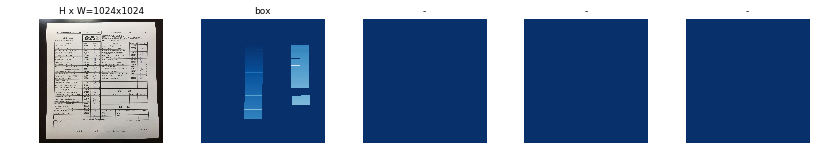

(55,)
(1024, 1024, 55)


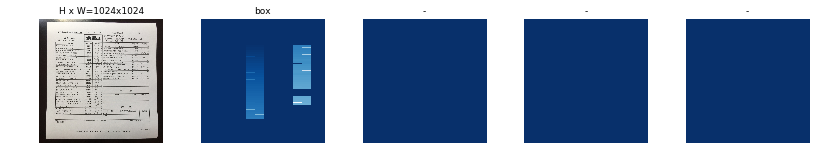

In [5]:
# Load and display random samples
plt.figure(figsize=(18, 18))
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids.shape)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

timer 5.962088346481323


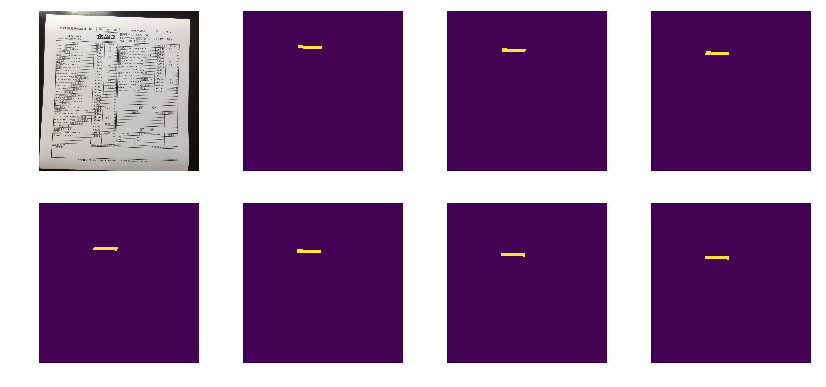

In [6]:
import time
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
start = time.time()
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id, use_mini_mask=False,augment=True)
end = time.time()
print("timer", end-start)

log("image", image)
log("image_meta", image_meta)

log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

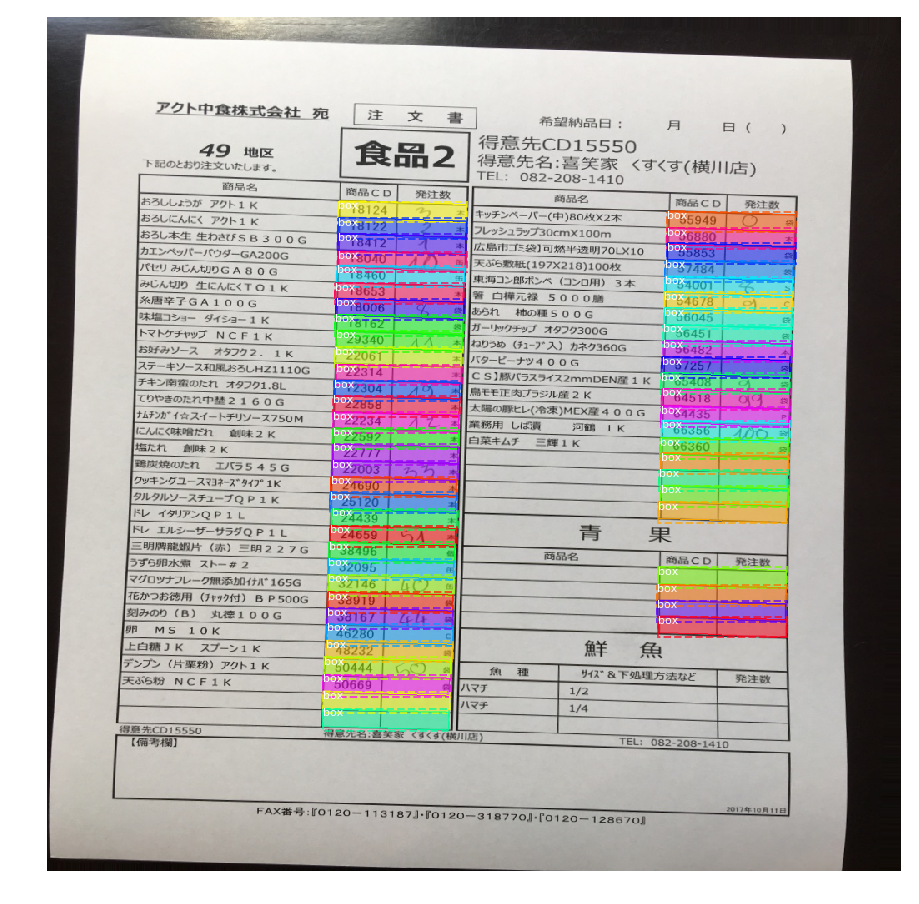

In [7]:
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [5]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [6]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/nghia/work/Mask_RCNN/logs/ocr20180314T1622/mask_rcnn_ocr_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branc

/home/nghia/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
100/100 [==============================] - 310s 3s/step - loss: 2.1001 - rpn_class_loss: 0.1735 - rpn_bbox_loss: 0.5309 - mrcnn_class_loss: 0.3716 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.6143 - val_loss: 2.1740 - val_rpn_class_loss: 0.1625 - val_rpn_bbox_loss: 0.7632 - val_mrcnn_class_loss: 0.3317 - val_mrcnn_bbox_loss: 0.3525 - val_mrcnn_mask_loss: 0.5640


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_ocr.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [7]:
class InferenceConfig(ocr.OcrConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nghia/work/Mask_RCNN/logs/ocr20180406T1009/mask_rcnn_ocr_0010.h5


(53, 4)
(1024, 1024, 53)
(53,)
(53,)


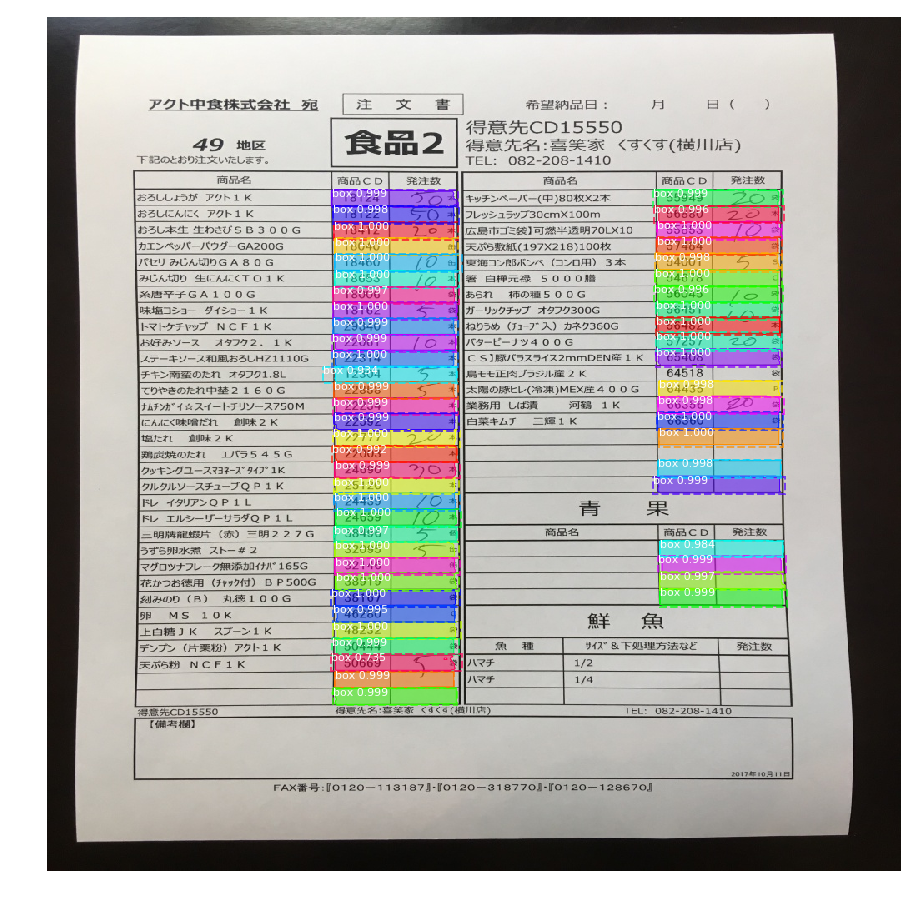

In [8]:
import skimage.io
import matplotlib.patches as patches

class_names = ['BG', 'box']
image_id = 3
# file_names = next(os.walk('data/image/'))[2]
# fn = 'imageresized_66.jpg'
# image = skimage.io.imread(os.path.join('data/image/', fn))
# image = skimage.io.imread('data/dataset_resized_ver2/imageresized_74.jpg')
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
print(r['rois'].shape)
print(r['masks'].shape)
print(r['class_ids'].shape)
print(r['scores'].shape)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# figsize = (16,16)
# _, ax = plt.subplots(1, figsize=figsize)

# print(r['rois'][0])
# y1, x1, y2, x2 = r['rois'][0]

# roi0 = image.copy()
# crop = roi0[int(x1):int(y1), int(x2):int(y2)]
# ax.imshow(crop)
# plt.show()

# _, ax = plt.subplots(1, figsize=figsize)
# y1, x1, y2, x2 = r['rois'][0]
# p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
#                       alpha=0.7, linestyle="dashed",
#                       edgecolor=(0.1, 0.2, 0.5), facecolor='none')
# ax.add_patch(p)
# ax.imshow(r['masks'][:, :, 0].astype(np.uint8))
# plt.show()
# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

## Evaluation

In [10]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
print(dataset_val.image_ids)
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

[0 1 2 3 4 5 6 7 8 9]
mAP:  0.9654545366764069
